# Path Tracking for a Discrete Single Integrator Model

## 1. System Model
We consider a mobile robot modeled as a **Discrete-Time Single Integrator**. The state $\mathbf{x} = [x_1, x_2]^T$ represents the Cartesian position. The dynamics are:
$$ \mathbf{x}(t+1) = \mathbf{x}(t) + \tau (\mathbf{u}(t) + \mathbf{w}(t)) $$
Where:
*   $\tau$: Sampling period.
*   $\mathbf{u}(t)$: Control input (velocity commands).
*   $\mathbf{w}(t)$: Disturbance/noise.

**Constraints:**
*   $\mathbb{X} = [-10, 10] \times [-10, 10]$ (Workspace limits)
*   $\mathbb{U} = [-1, 1] \times [-1, 1]$ (Speed limits)
*   $\mathbb{W} = [-0.05, 0.05] \times [-0.05, 0.05]$ (Disturbance bounds)

## 2. Tracking Error Dynamics
Let $\mathbf{x}_{ref}(t)$ be the desired trajectory. We define the tracking error as:
$$ \mathbf{e}(t) = \mathbf{x}(t) - \mathbf{x}_{ref}(t) $$
The evolution of the error at $t+1$ is:
$$ \mathbf{e}(t+1) = \mathbf{e}(t) + \tau \mathbf{u}(t) - \Delta \mathbf{x}_{ref}(t) + \tau \mathbf{w}(t) $$
Where $\Delta \mathbf{x}_{ref}(t) = \mathbf{x}_{ref}(t+1) - \mathbf{x}_{ref}(t)$.

## 3. Full State Feedback Control Law
To drive $\mathbf{e}(t) \to 0$, we use a control law combining **Feedforward** (to follow the path's motion) and **Feedback** (to correct drift):
$$ \mathbf{u}(t) = \underbrace{\frac{1}{\tau} \Delta \mathbf{x}_{ref}(t)}_{\text{Feedforward}} - \underbrace{\mathbf{K} \mathbf{e}(t)}_{\text{Feedback}} $$

Substituting this into the error dynamics yields:
$$ \mathbf{e}(t+1) = (1 - \tau \mathbf{K}) \mathbf{e}(t) + \tau \mathbf{w}(t) $$
For stability in discrete time, the gain $\mathbf{K}$ must be chosen such that $|1 - \tau \mathbf{K}| < 1$.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


In [41]:
# Simulation Parameters
tau = 0.1          # Sampling time (s)
u_limit = 1.0      # Input constraint [-1, 1]
w_bound = 0.05     # Noise bound
lmbda = 0.8        # Desired closed-loop pole (0 < lmbda < 1)

# Gain Calculation
K = (1 - lmbda) / tau
print(f"Calculated Feedback Gain K: {K}")


Calculated Feedback Gain K: 1.9999999999999996


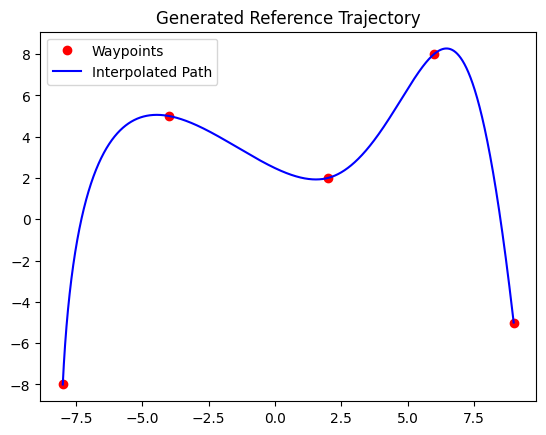

In [42]:
# 1. Define 5 arbitrary waypoints
waypoints = np.array([
    [ -8,  -8],
    [ -4,   5],
    [  2,   2],
    [  6,   8],
    [  9,  -5]
])

# # Circle
# radius = 7
# angles = np.linspace(0, 2 * np.pi, 6) # 6 points to close the circle (0 to 360 degrees)

# waypoints = np.array([
#     [radius * np.cos(a), radius * np.sin(a)] for a in angles
# ])

# 2. Interpolate to create a smooth trajectory
steps = 5000
s = np.linspace(0, 1, len(waypoints))
s_fine = np.linspace(0, 1, steps)

# Use CubicSpline for smooth x and y paths
cs = CubicSpline(s, waypoints)
path = cs(s_fine) # This is our x_ref(t)

plt.plot(waypoints[:,0], waypoints[:,1], 'ro', label='Waypoints')
plt.plot(path[:,0], path[:,1], 'b-', label='Interpolated Path')
plt.title("Generated Reference Trajectory")
plt.legend()
plt.show()


In [43]:
# --- CHANGE THIS TO TEST STARTING POINTS ---
start_pos = np.array([-2.0, -5.0]) 
# -------------------------------------------

curr_x = start_pos.copy()
history = []

for t in range(steps - 1):
    history.append(curr_x.copy())
    
    # 1. Calculate Error e(t)
    error = curr_x - path[t]
    
    # 2. Calculate Feedforward (Change in path)
    u_ff = (path[t+1] - path[t]) / tau
    
    # 3. Control Law: u = u_ff - K*e
    u = u_ff - K * error
    
    # 4. Apply Saturation (Constraint U)
    u = np.clip(u, -u_limit, u_limit)
    
    # 5. Physics Update with Noise (Constraint W)
    w = np.random.uniform(-w_bound, w_bound, size=2)
    curr_x = curr_x + tau * (u + w)

history = np.array(history)
print("Simulation Complete.")


Simulation Complete.


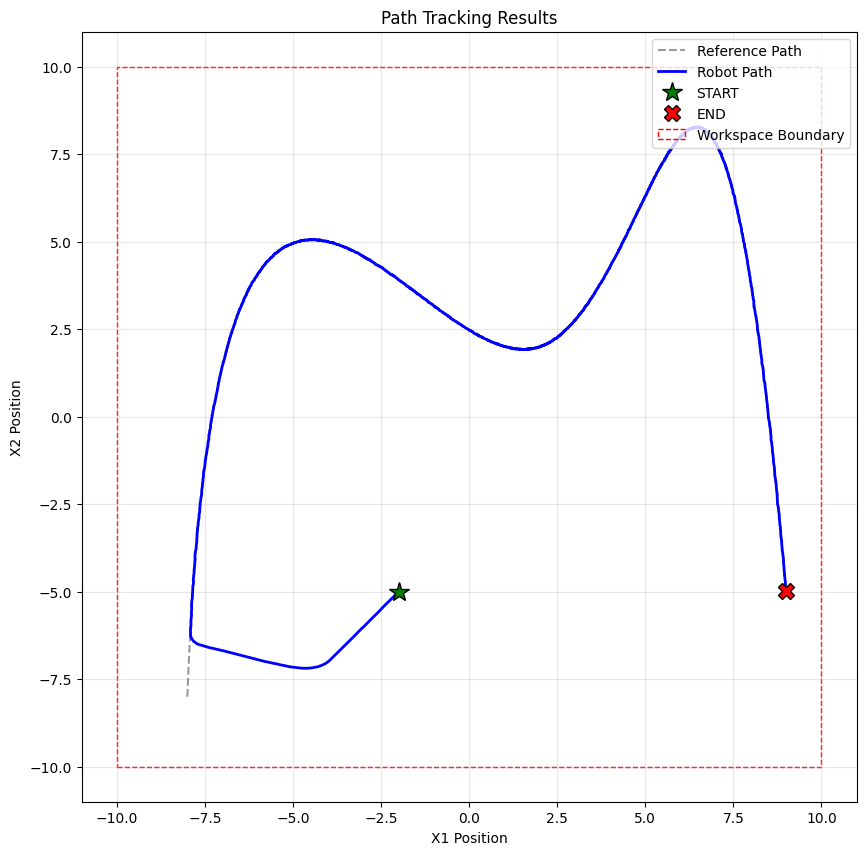

In [44]:
plt.figure(figsize=(10, 10))

# Plot Reference Path
plt.plot(path[:, 0], path[:, 1], 'k--', alpha=0.4, label='Reference Path')

# Plot Robot Trajectory
plt.plot(history[:, 0], history[:, 1], 'b-', linewidth=2, label='Robot Path')

# Markers
plt.plot(history[0, 0], history[0, 1], 'g*', markersize=15, label='START', markeredgecolor='k')
plt.plot(history[-1, 0], history[-1, 1], 'rX', markersize=12, label='END', markeredgecolor='k')

# Workspace Constraints (X from slide)
plt.gca().add_patch(plt.Rectangle((-10, -10), 20, 20, fill=False, color='red', linestyle='--', label='Workspace Boundary'))

plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.xlabel("X1 Position")
plt.ylabel("X2 Position")
plt.title("Path Tracking Results")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()


# Optimal Path Tracking via Discrete LQR

## 1. Error State-Space Representation
To minimize tracking error $\mathbf{e}(t) = \mathbf{x}(t) - \mathbf{x}_{ref}(t)$, we define the discrete-time error dynamics (ignoring feedforward and noise components for the design of the feedback gain):
$$\mathbf{e}(t+1) = \mathbf{A}_d \mathbf{e}(t) + \mathbf{B}_d \mathbf{u}_{fb}(t)$$
For a single integrator with sampling period $\tau$:
*   $\mathbf{A}_d = \mathbf{I}$ (Identity matrix)
*   $\mathbf{B}_d = \tau \mathbf{I}$

## 2. Objective Function (Cost)
LQR finds the optimal feedback gain $\mathbf{K}$ by minimizing the quadratic cost function $J$:
$$J = \sum_{t=0}^{\infty} \left( \mathbf{e}(t)^T \mathbf{Q} \mathbf{e}(t) + \mathbf{u}_{fb}(t)^T \mathbf{R} \mathbf{u}_{fb}(t) \right)$$
*   $\mathbf{Q}$: Penalty for **Tracking Error** (State cost).
*   $\mathbf{R}$: Penalty for **Control Effort** (Input cost).

## 3. Solving for the Optimal Gain
1.  **Solve the Discrete Algebraic Riccati Equation (DARE)** to find the steady-state cost matrix $\mathbf{P}$:
    $$\mathbf{P} = \mathbf{A}_d^T \mathbf{P} \mathbf{A}_d - (\mathbf{A}_d^T \mathbf{P} \mathbf{B}_d)(\mathbf{R} + \mathbf{B}_d^T \mathbf{P} \mathbf{B}_d)^{-1}(\mathbf{B}_d^T \mathbf{P} \mathbf{A}_d) + \mathbf{Q}$$
2.  **Compute the Optimal Feedback Gain $\mathbf{K}$**:
    $$\mathbf{K} = (\mathbf{R} + \mathbf{B}_d^T \mathbf{P} \mathbf{B}_d)^{-1} (\mathbf{B}_d^T \mathbf{P} \mathbf{A}_d)$$

## 4. Final Control Law
The total control input combines the **Optimal Feedback** and the **Trajectory Feedforward**:
$$\mathbf{u}(t) = \underbrace{\frac{1}{\tau} \Delta \mathbf{x}_{ref}(t)}_{\text{Feedforward}} - \underbrace{\mathbf{K} \mathbf{e}(t)}_{\text{LQR Feedback}}$$

---

### Why is the Disturbance $\mathbf{w}(t)$ ignored during design?
1.  **Certainty Equivalence Principle:** In linear systems with additive white noise, the optimal controller for the noisy system is identical to the optimal controller for the noise-free system.
2.  **Feedback as Rejection:** The gain $\mathbf{K}$ is the mechanism used to reject disturbances. By penalizing error ($\mathbf{Q}$), LQR automatically calculates the optimal "restoring force" to bring the system back to the path after a disturbance occurs.
3.  **Separation:** Disturbance estimation (e.g., Kalman Filter) and State Feedback (LQR) are mathematically independent tasks.


In [45]:
from scipy.linalg import solve_discrete_are


In [46]:
# Simulation Parameters
tau = 0.1          # Sampling time (s)
u_limit = 1.0      # Input constraint [-1, 1]
w_bound = 0.05     # Noise bound

# 1. Define Discrete-Time System Matrices (A and B)
# e(t+1) = A*e(t) + B*u_fb(t)
A = np.eye(2)      
B = tau * np.eye(2)

# 2. Define LQR Weights
# Q: Penalty for tracking error (Higher = follow path tighter)
Q = np.array([
    [10.0, 0.0],
    [0.0, 10.0]
])

# R: Penalty for control effort (Higher = smoother/slower movement)
R = np.array([
    [1.0, 0.0],
    [0.0, 1.0]
])

# 3. Solve the Discrete Algebraic Riccati Equation (DARE)
# This finds the optimal cost-to-go matrix P
P = solve_discrete_are(A, B, Q, R)

# 4. Calculate the Optimal Gain K
# K = (R + B.T @ P @ B)^-1 @ (B.T @ P @ A)
K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

print("Calculated LQR Gain Matrix K:")
print(K)


Calculated LQR Gain Matrix K:
[[2.70156212 0.        ]
 [0.         2.70156212]]


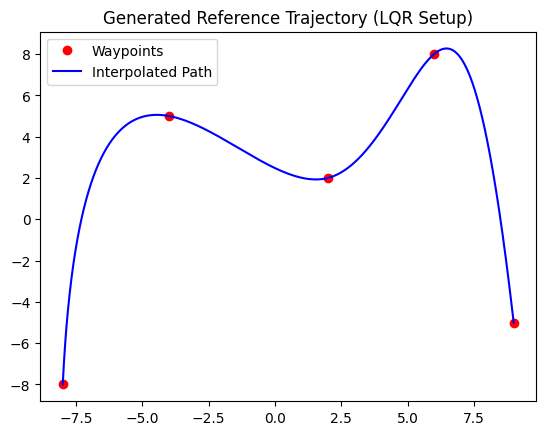

In [53]:
waypoints = np.array([
    [ -8,  -8],
    [ -4,   5],
    [  2,   2],
    [  6,   8],
    [  9,  -5]
])

steps = 5000
s = np.linspace(0, 1, len(waypoints))
s_fine = np.linspace(0, 1, steps)

cs = CubicSpline(s, waypoints)
path = cs(s_fine)

plt.plot(waypoints[:,0], waypoints[:,1], 'ro', label='Waypoints')
plt.plot(path[:,0], path[:,1], 'b-', label='Interpolated Path')
plt.title("Generated Reference Trajectory (LQR Setup)")
plt.legend()
plt.show()


In [54]:
# --- CHANGE THIS TO TEST STARTING POINTS ---
start_pos = np.array([-2.0, -5.0]) 
# -------------------------------------------

curr_x = start_pos.copy()
history = []

for t in range(steps - 1):
    history.append(curr_x.copy())
    
    # 1. Calculate Error e(t)
    error = curr_x - path[t]
    
    # 2. Calculate Feedforward
    u_ff = (path[t+1] - path[t]) / tau
    
    # 3. LQR Control Law: u = u_ff - K @ e
    # We use @ for matrix multiplication
    u_fb = -K @ error
    u = u_ff + u_fb
    
    # 4. Apply Saturation
    u = np.clip(u, -u_limit, u_limit)
    
    # 5. Physics Update with Noise
    w = np.random.uniform(-w_bound, w_bound, size=2)
    curr_x = curr_x + tau * (u + w)

history = np.array(history)
print("LQR Simulation Complete.")


LQR Simulation Complete.


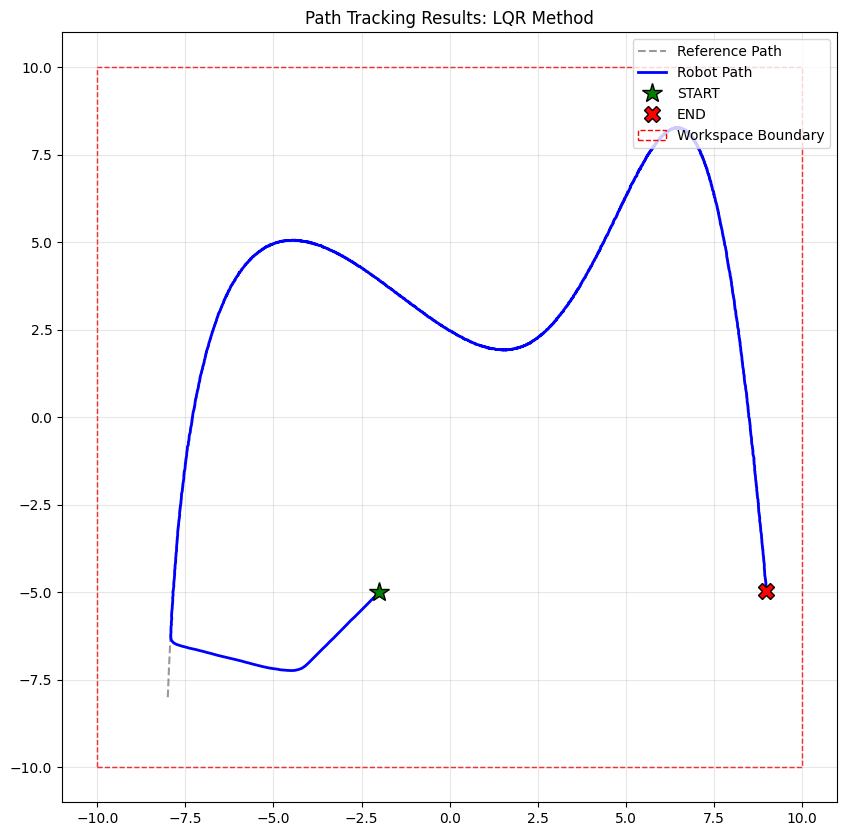

In [55]:
plt.figure(figsize=(10, 10))
plt.plot(path[:, 0], path[:, 1], 'k--', alpha=0.4, label='Reference Path')
plt.plot(history[:, 0], history[:, 1], 'b-', linewidth=2, label='Robot Path')
plt.plot(history[0, 0], history[0, 1], 'g*', markersize=15, label='START', markeredgecolor='k')
plt.plot(history[-1, 0], history[-1, 1], 'rX', markersize=12, label='END', markeredgecolor='k')
plt.gca().add_patch(plt.Rectangle((-10, -10), 20, 20, fill=False, color='red', linestyle='--', label='Workspace Boundary'))
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.title("Path Tracking Results: LQR Method")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()
